# MINI PROJET 1: Qui a peint ce tableau ?

In [1]:
# Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image


# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-11-18 11:28:09.367199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 11:28:10.081797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 11:28:10.304917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 11:28:11.949859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 11:28:30.459435: W tensorflow/comp

In [2]:
# tf.config.list_physical_devices()
[k.device_type for k in tf.config.list_physical_devices()]

2024-11-18 11:28:49.531712: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


['CPU']

## Preparation du jeu de données

In [3]:
# Vérifie si le dossier "data" existe, et le supprime s'il est présent.
if os.path.exists("data"):
  shutil.rmtree("data")  # Supprime le dossier et tout son contenu

# Définition du chemin vers le dossier contenant les images des auteurs.
path = "./images_hq/"

# Initialisation d'une liste pour stocker les labels (noms d'auteurs).
labels = []

# Si le dossier "data" n'existe pas, il est créé.
if not os.path.exists("data"):
    os.mkdir("data")  # Crée un nouveau dossier "data"

# Parcours du contenu du dossier `path` (dossier contenant les sous-dossiers d'auteurs).
for author_folder in os.listdir(path):
    # Pour chaque sous-dossier d'auteur, obtient le chemin complet.
    author_path = os.path.join(path, author_folder)
    
    # Parcours de chaque image dans le sous-dossier de l'auteur.
    for image_filename in os.listdir(author_path):
        # Initialisation d'une chaîne vide pour stocker le nom de l'auteur.
        author_name = ""
        
        # Séparation du nom de fichier selon les underscores ('_'), pour reconstruire le nom de l'auteur.
        # L'image est supposée être nommée avec le format "prénom_nom_numéro.jpg"
        # On extrait ici toutes les parties du nom avant le dernier underscore.
        for i in range(len(image_filename.split('_')) - 1):
            author_name += image_filename.split('_')[i] 
            # La ligne suivante (en commentaire) sert à tester ou déboguer si nécessaire
            #print(author_name, author_folder)
    
        # Copie le fichier d'image depuis son emplacement d'origine vers le dossier "data".
        src = os.path.join(author_path, image_filename)  # Chemin source
        dst = os.path.join("data/", image_filename)  # Chemin destination
        shutil.copyfile(src, dst)  # Copie le fichier d'origine vers la destination
        
        # Ajoute le nom de l'auteur à la liste des labels.
        labels.append(author_name)

# Liste tous les fichiers dans le dossier "data", qui sont les fichiers d'image copiés.
train_filename = os.listdir("data")

In [4]:
len(labels),len(train_filename)

(8446, 8446)

In [5]:
total_df = pd.DataFrame({
    'filename': train_filename,
    'auteur': labels
})

In [6]:
total_df.shape

(8446, 2)

In [7]:
total_df.head()

filename         auteur
0    Albrecht_Dürer_1.jpg  AlbrechtDürer
1   Albrecht_Dürer_10.jpg  AlbrechtDürer
2  Albrecht_Dürer_100.jpg  AlbrechtDürer
3  Albrecht_Dürer_101.jpg  AlbrechtDürer
4  Albrecht_Dürer_102.jpg  AlbrechtDürer

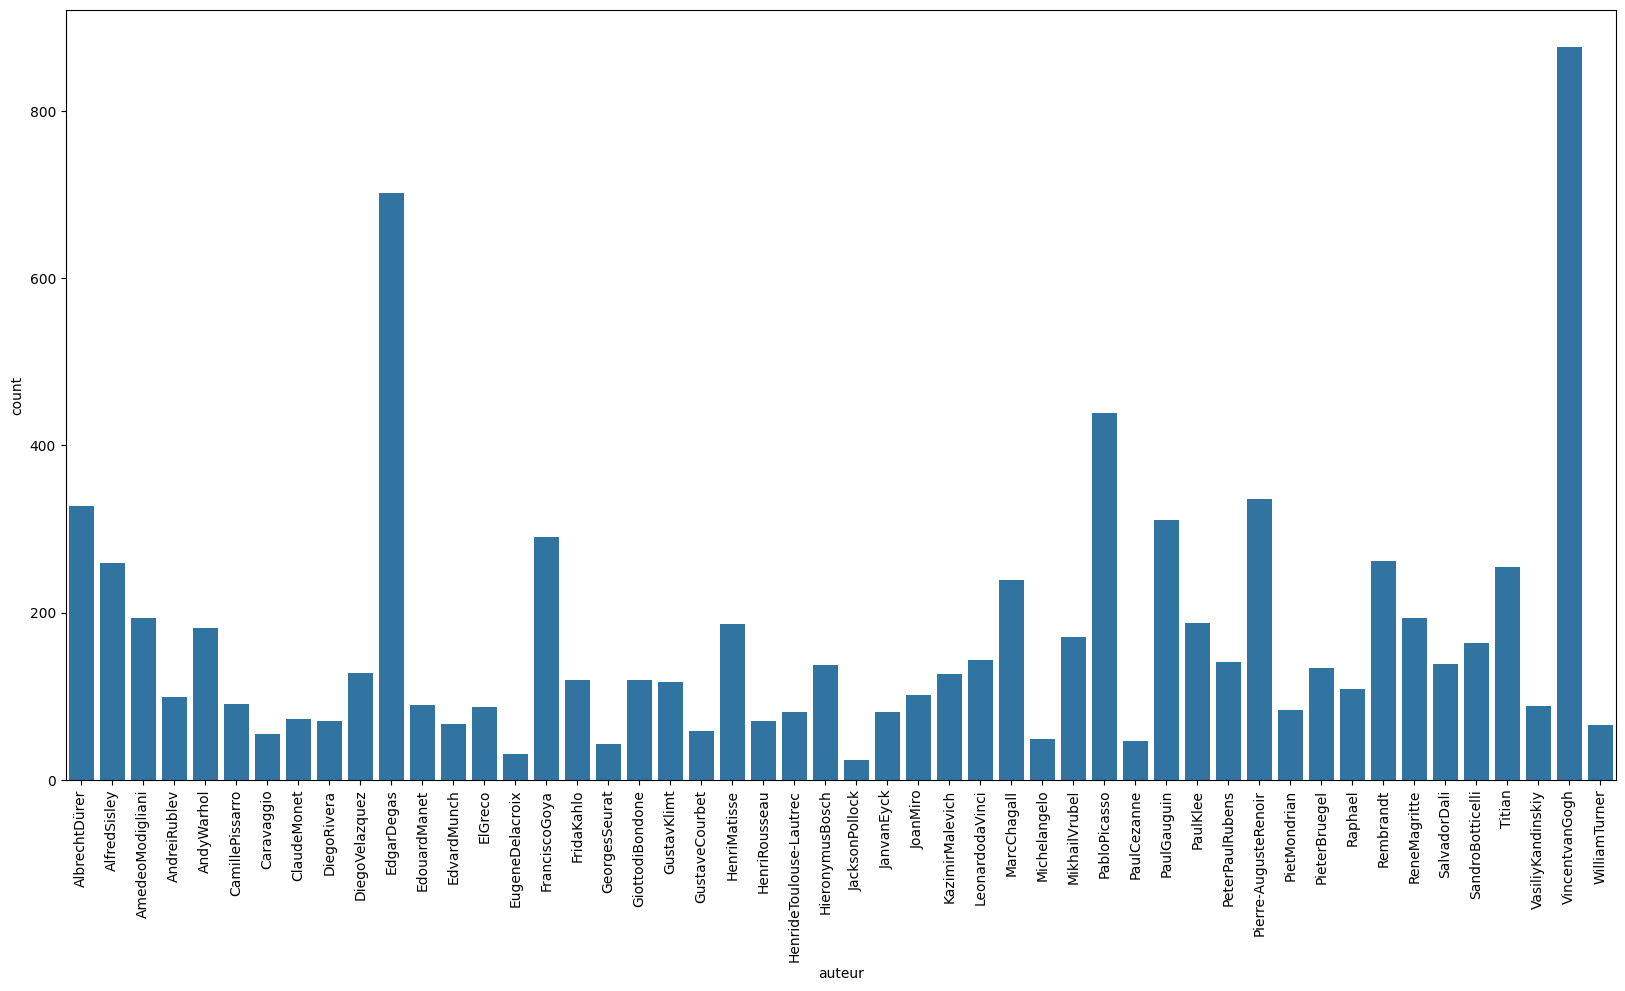

In [8]:
plt.figure(figsize=(20,10))
sns.countplot(x=total_df["auteur"])
plt.xticks(rotation=90)
plt.show()

In [9]:
sorted_data = total_df.iloc[:, 1].value_counts(ascending=False)
sorted_data

auteur
VincentvanGogh             877
EdgarDegas                 702
PabloPicasso               439
Pierre-AugusteRenoir       336
AlbrechtDürer              328
PaulGauguin                311
FranciscoGoya              291
Rembrandt                  262
AlfredSisley               259
Titian                     255
MarcChagall                239
ReneMagritte               194
AmedeoModigliani           193
PaulKlee                   188
HenriMatisse               186
AndyWarhol                 181
MikhailVrubel              171
SandroBotticelli           164
LeonardodaVinci            143
PeterPaulRubens            141
SalvadorDali               139
HieronymusBosch            137
PieterBruegel              134
DiegoVelazquez             128
KazimirMalevich            126
FridaKahlo                 120
GiottodiBondone            119
GustavKlimt                117
Raphael                    109
JoanMiro                   102
AndreiRublev                99
CamillePissarro             91
E

Nous constatons que nos données présentent un déséquilibre dans la répartition des étiquettes. Cela peut entraîner :
   + Déséquilibre de la précision entre les classes : Lorsque certaines classes ont beaucoup moins d'exemples que d'autres, le modèle CNN peut biaiser ses prédictions en faveur des classes les plus représentées. Cela signifie que le modèle aura une précision moindre pour les classes sous-représentées.
   + Réduction de la précision globale et de la capacité de généralisation : Un déséquilibre des classes peut empêcher le modèle d'apprendre correctement les caractéristiques des classes minoritaires, réduisant ainsi sa capacité de généralisation. Le modèle peut afficher une précision globale élevée, mais cela ne reflète pas sa réelle efficacité pour les classes moins fréquentes.
   + Augmentation du risque de surapprentissage (overfitting) pour les classes minoritaires : Lorsque les classes minoritaires ont très peu d'exemples, le modèle risque de surapprendre ces échantillons spécifiques sans généraliser correctement. Cela signifie que le modèle pourra reconnaître ces exemples en particulier, mais sera inefficace avec des exemples nouveaux appartenant aux mêmes classes.


In [10]:
auteur_counts = total_df['auteur'].value_counts()

# 2. Filtrer les auteurs qui ont au moins 150 images
auteurs_150_plus = auteur_counts[auteur_counts >= 150].index
filtered_df = total_df[total_df['auteur'].isin(auteurs_150_plus)]

# 3. Limiter à un maximum de 450 images par auteur
def reduce_images(df, max_images=450):
    if len(df) > max_images:
        return df.sample(n=max_images, random_state=42)  # Échantillonnage aléatoire
    return df

# Appliquer la réduction pour chaque auteur
balanced_df = filtered_df.groupby('auteur').apply(reduce_images).reset_index(drop=True)

# Afficher le résultat
print("Taille du DataFrame après équilibrage :", balanced_df.shape)
print(balanced_df['auteur'].value_counts())

Taille du DataFrame après équilibrage : (4897, 2)
auteur
VincentvanGogh          450
EdgarDegas              450
PabloPicasso            439
Pierre-AugusteRenoir    336
AlbrechtDürer           328
PaulGauguin             311
FranciscoGoya           291
Rembrandt               262
AlfredSisley            259
Titian                  255
MarcChagall             239
ReneMagritte            194
AmedeoModigliani        193
PaulKlee                188
HenriMatisse            186
AndyWarhol              181
MikhailVrubel           171
SandroBotticelli        164
Name: count, dtype: int64


/tmp/ipykernel_3332/3936962798.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = filtered_df.groupby('auteur').apply(reduce_images).reset_index(drop=True)


In [11]:
total_df=balanced_df
nclasses=len(total_df.auteur.unique())
total_df.shape, nclasses


((4897, 2), 18)

## Visualisation des images

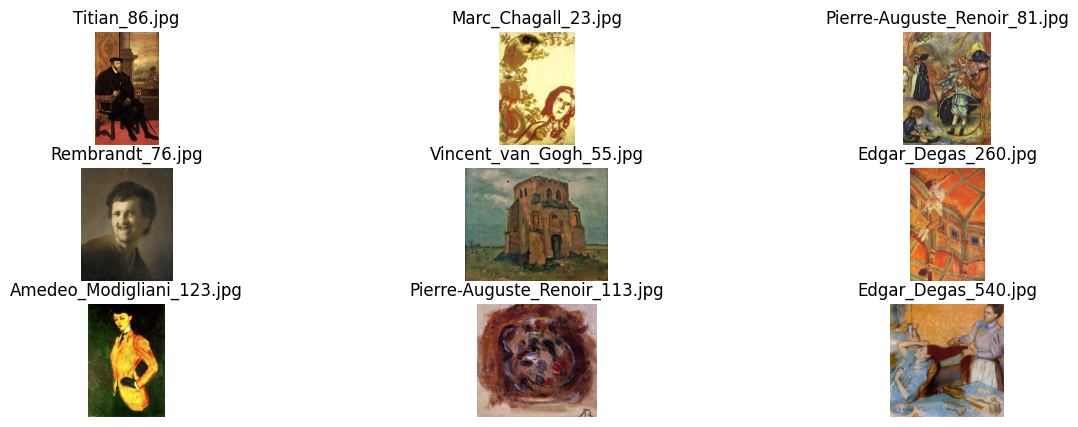

In [12]:
from tensorflow.keras.utils import load_img, img_to_array
fig,axe=plt.subplots(3,3,figsize=(15,5))

for i in range(3):
    for j in range(3):
        filename = rd.choice(total_df['filename'])
        img = load_img("data/" + filename)

          # Sélectionne une image appartenant à la classe k
        
        # Affiche l'image sur l'axe correspondant
        axe[i, j].imshow(img)  # Ajuster cmap selon vos images (ex: 'gray' pour images en niveaux de gris)
        axe[i, j].set_title(filename)  # Ajoute un titre pour chaque sous-graphe
        axe[i, j].axis('off')
    

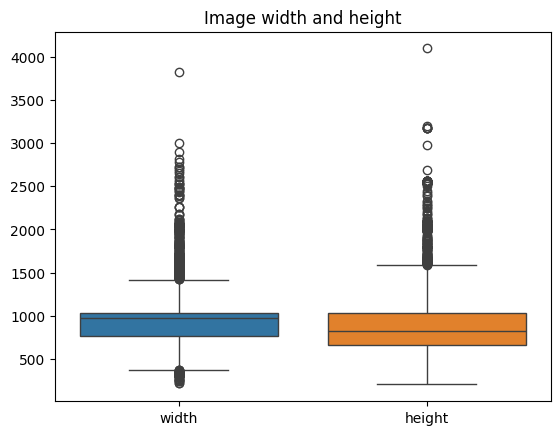

In [13]:
img_size = np.zeros((total_df.shape[0],2))
for i, filename in enumerate(total_df['filename']) :
    img = img_to_array( load_img("data/"+filename) )
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()


## Pretraitement

In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Encode the 'category' column
total_df['auteur'] = label_encoder.fit_transform(total_df['auteur'])
total_df["auteur"]=total_df["auteur"].astype("str")

# Display the updated DataFrame
total_df.head()

filename auteur
0    Albrecht_Dürer_1.jpg      0
1   Albrecht_Dürer_10.jpg      0
2  Albrecht_Dürer_100.jpg      0
3  Albrecht_Dürer_101.jpg      0
4  Albrecht_Dürer_102.jpg      0

In [16]:
from sklearn.model_selection import train_test_split

# Sépare le dataset 'total_df' en deux sous-ensembles : un ensemble d'entraînement (train_df) et un ensemble de test (test_df).
# La taille de l'ensemble de test est de 20% du dataset total.
train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)

# Sépare ensuite l'ensemble d'entraînement (train_df) en deux sous-ensembles : un ensemble d'entraînement (train_df) et un ensemble de validation (val_df).
# La taille de l'ensemble de validation est de 25% de l'ensemble d'entraînement initial (soit 25% de 80%, ce qui correspond à 20% du dataset total).
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  


In [17]:
total_df.dtypes

filename    object
auteur      object
dtype: object

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 32 # Nombre d'images à traiter à chaque itération de l'entraînement.
img_width = 224 # Largeur cible des images après redimensionnement.
img_height = 224 # Hauteur cible des images après redimensionnement.

# Crée un générateur d'images pour l'ensemble d'entraînement en normalisant les pixels (valeurs entre 0 et 1).
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
     "data/",
    x_col = 'filename',
    y_col = 'auteur',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
     "data/",
    x_col = 'filename',
    y_col = 'auteur',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
     "data/",
    x_col = 'filename',
    y_col = 'auteur',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)


Found 2937 validated image filenames belonging to 18 classes.
Found 980 validated image filenames belonging to 18 classes.
Found 980 validated image filenames belonging to 18 classes.


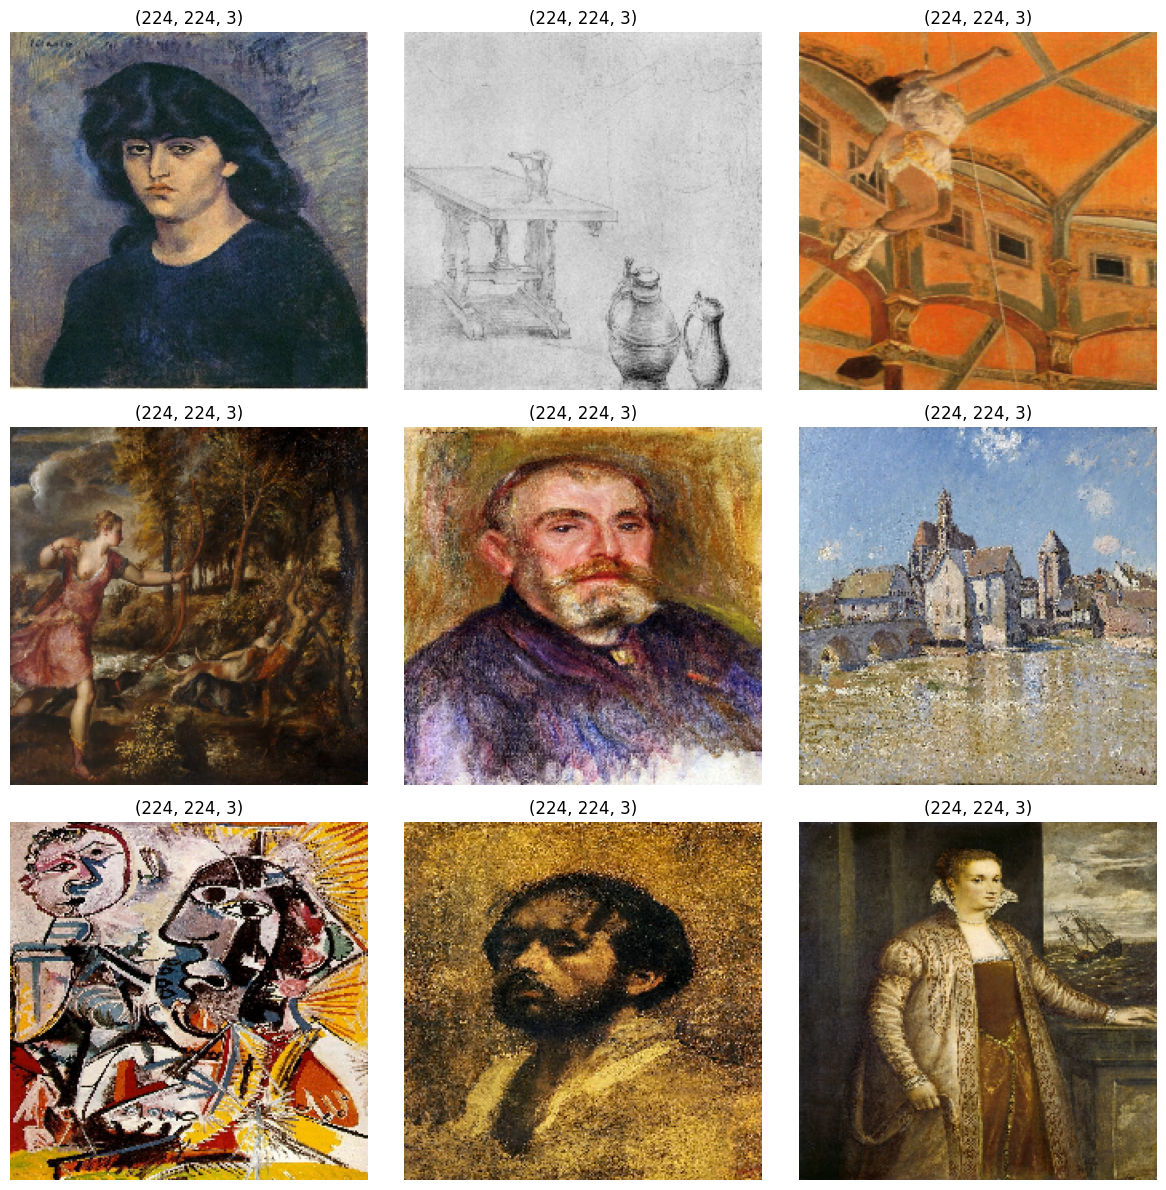

In [19]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        
        plt.title(str(img.shape))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

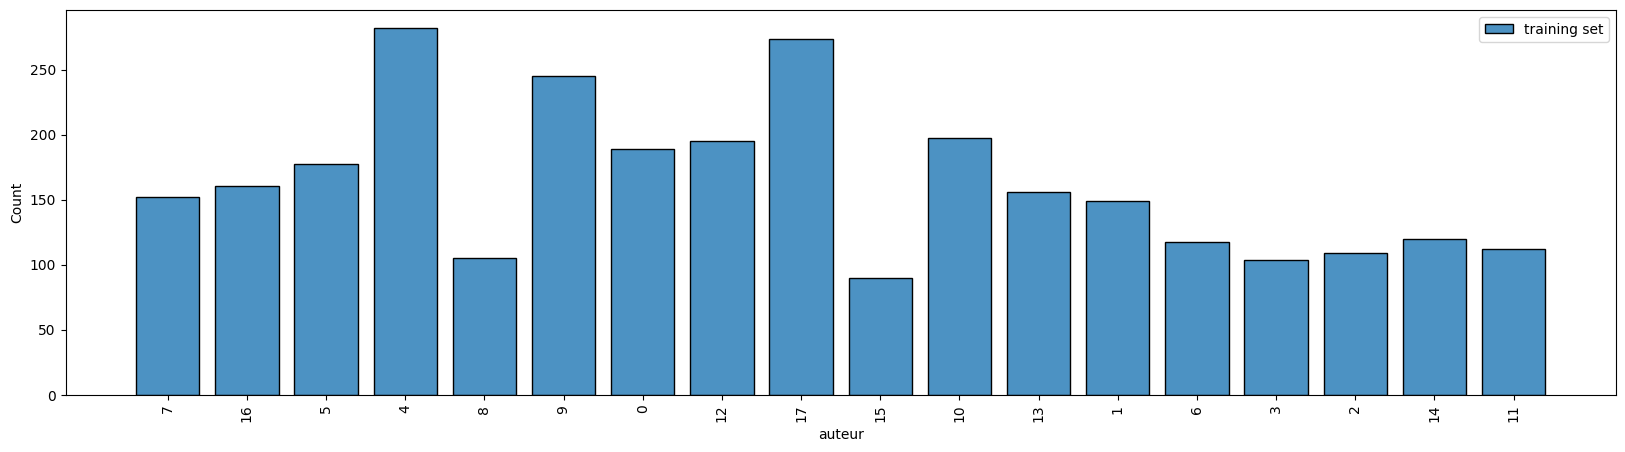

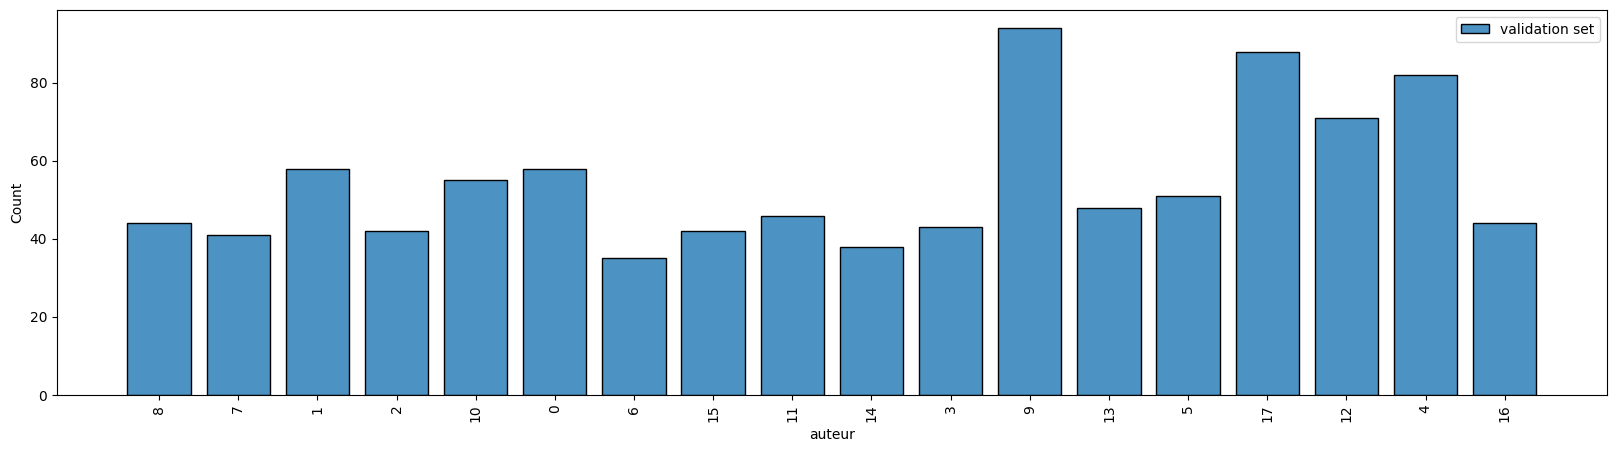

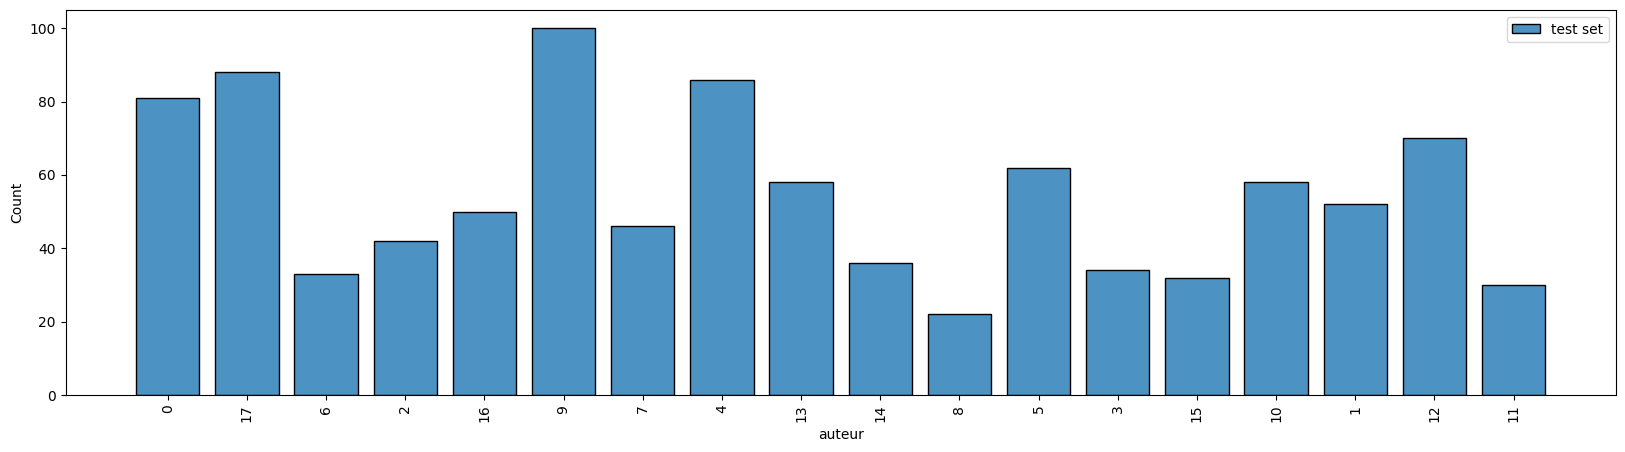

In [20]:
plt.figure(figsize=(20,5))

sns.histplot(train_df.iloc[:,1],label="training set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(20,5))
sns.histplot(val_df.iloc[:,1],label="validation set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(20,5))
sns.histplot(test_df.iloc[:,1],label="test set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)
plt.legend()

## First approach: Transfer Learning avec VGG16

In [23]:
from tensorflow.keras.applications import VGG16

In [24]:
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0], -1))

validation_features = conv_base.predict(val_generator)
validation_features = np.reshape(validation_features,(validation_features.shape[0], -1))

/home/gadj/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step


In [27]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,1]])

validation_data = val_df.to_numpy()
y_validation = np.array([int(numeric_string) for numeric_string in validation_data[:,1]])

In [28]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=nclasses)
y_validation = to_categorical(y_validation, num_classes=nclasses)

In [30]:
vgg_mlp = Sequential()
vgg_mlp.add( Input((train_features.shape[1],)) )
vgg_mlp.add(Dense(256, activation='relu'))
vgg_mlp.add(Dropout(0.5))
vgg_mlp.add(Dense(nclasses, activation='softmax'))

vgg_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,427,410 (24.52 MB)

 Trainable params: 6,427,410 (24.52 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
epochs = 50

vgg_mlp.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_mlp = time.time()
vgg_mlp_history = vgg_mlp.fit(
    train_features, y_train,
    validation_data = (validation_features, y_validation),
    epochs = epochs
)
t_learning_vgg_mlp = time.time() - t_learning_vgg_mlp

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_mlp))

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.1293 - loss: 2.6880 - val_accuracy: 0.0837 - val_loss: 2.9592
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1232 - loss: 2.6769 - val_accuracy: 0.0827 - val_loss: 2.9850
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1251 - loss: 2.6854 - val_accuracy: 0.0827 - val_loss: 2.9951
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.1225 - loss: 2.6886 - val_accuracy: 0.0827 - val_loss: 3.0015
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1263 - loss: 2.6630 - val_accuracy: 0.0837 - val_loss: 3.0173
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1247 - loss: 2.6654 - val_accuracy: 0.0816 - val_loss: 3.0446
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1232 - loss: 2.6706 - val_accuracy: 0.0816 - val_loss: 3.0437
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1198 - loss: 2.6894 - val_accuracy: 0.0867 - v

In [36]:
t_prediction_vgg_mlp = time.time()

score_vgg_mlp_train = vgg_mlp.evaluate(train_features, y_train)
score_vgg_mlp_validation = vgg_mlp.evaluate(validation_features, y_validation)

t_prediction_vgg_mlp = time.time() - t_prediction_vgg_mlp

print('Train accuracy:', score_vgg_mlp_train[1])
print('Validation accuracy:', score_vgg_mlp_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_mlp )

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1903 - loss: 2.4451
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0820 - loss: 3.2517
Train accuracy: 0.18113721907138824
Validation accuracy: 0.09081632643938065
Time Prediction: 1.36 seconds


In [37]:
# %load solutions/CatsDogs/plot_training_analysis.py
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

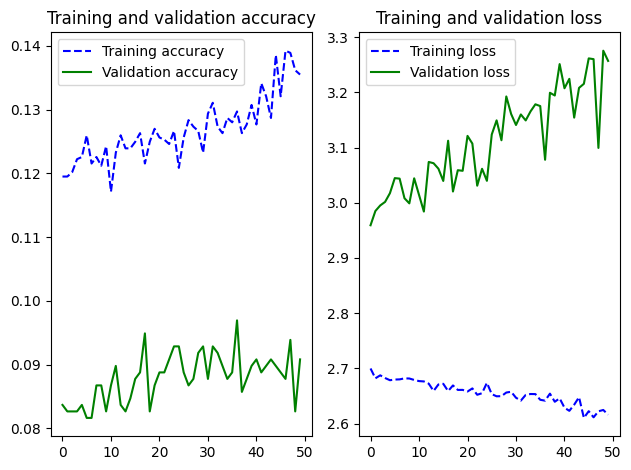

In [38]:
plot_training_analysis(vgg_mlp_history)

# Second Approach: Transfer learning with data augmentation

In [40]:
# Data Augmentation using ImageDataGenerator
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation aléatoire de 20 degrés
    width_shift_range=0.2,  # Décalage horizontal aléatoire de 20%
    height_shift_range=0.2,  # Décalage vertical aléatoire de 20%
    shear_range=0.2,  # Déformation par cisaillement aléatoire de 20%
    zoom_range=0.2,  # Zoom aléatoire de 20%
    horizontal_flip=True,  # Retournement horizontal aléatoire
    fill_mode='nearest'  # Méthode de remplissage pour les pixels manquants
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    "data/",
    x_col='filename',
    y_col='auteur',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size
)

Found 2937 validated image filenames belonging to 18 classes.


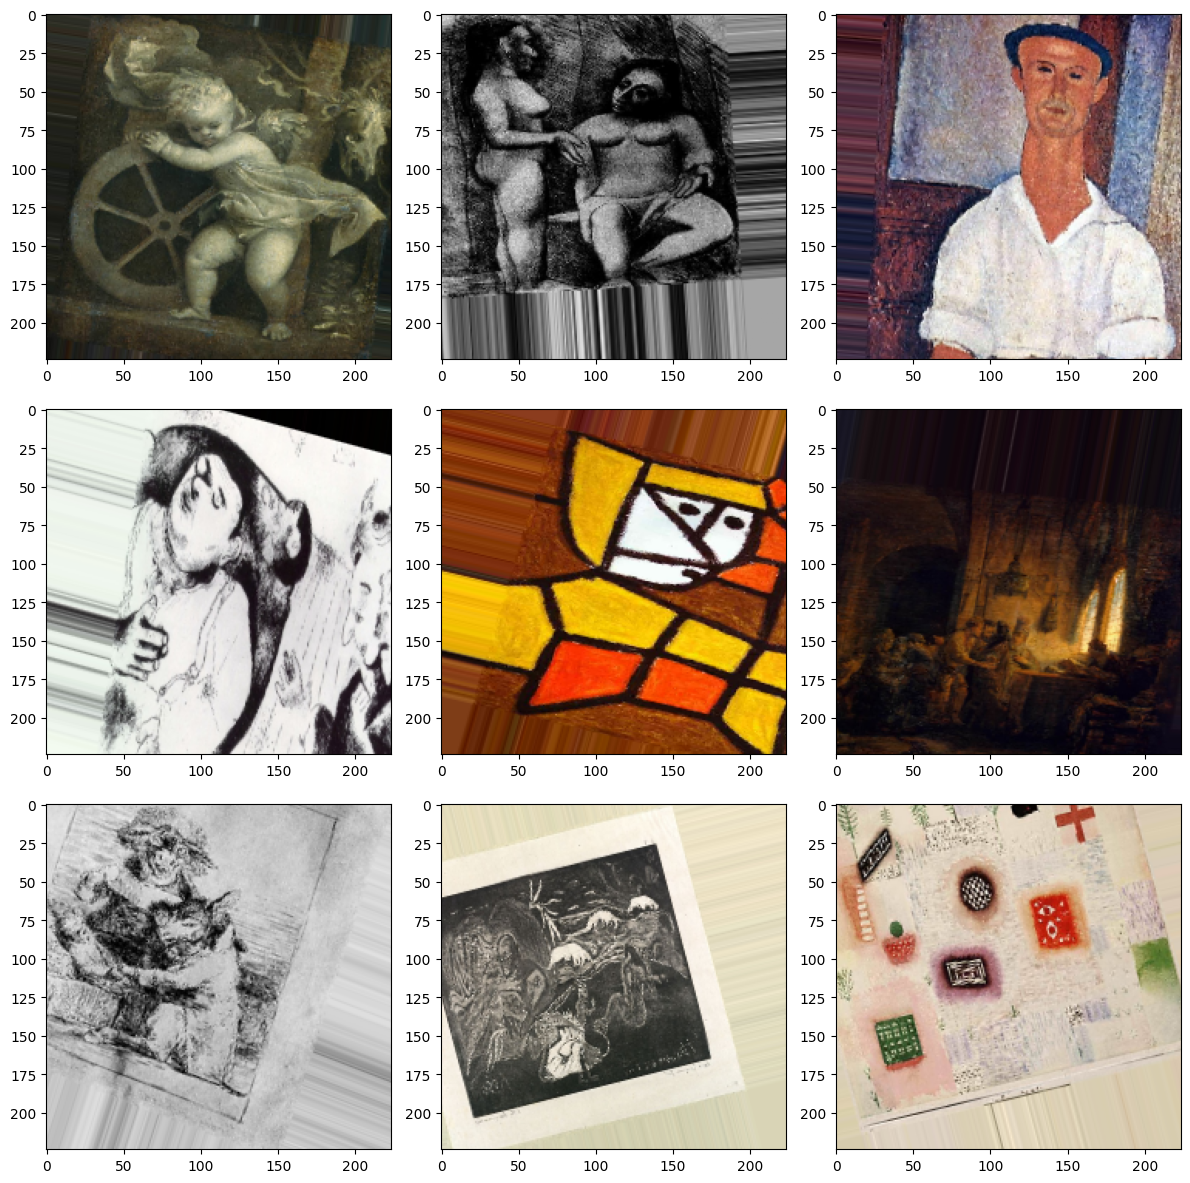

In [44]:
plt.figure(figsize=(12, 12))

example_x, example_y = next(train_generator_augmented)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i])
    #plt.title(labels.get(example_y[i]))

plt.tight_layout()
plt.show()

In [45]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(nclasses, activation='softmax'))

vgg_combined.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 21,142,098 (80.65 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
conv_base.trainable = False
vgg_combined.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,142,098 (80.65 MB)

 Trainable params: 6,427,410 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [47]:
epochs = 10

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented, 
    validation_data = val_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Epoch 1/10


/home/gadj/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 546s 6s/step - accuracy: 0.2265 - loss: 2.7184 - val_accuracy: 0.4827 - val_loss: 1.7525
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 543s 6s/step - accuracy: 0.4775 - loss: 1.7145 - val_accuracy: 0.4929 - val_loss: 1.5606
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 543s 6s/step - accuracy: 0.5350 - loss: 1.4522 - val_accuracy: 0.5592 - val_loss: 1.4087
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 543s 6s/step - accuracy: 0.5717 - loss: 1.3451 - val_accuracy: 0.6051 - val_loss: 1.3217
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.6082 - loss: 1.2742 - val_accuracy: 0.6143 - val_loss: 1.2425
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 550s 6s/step - accuracy: 0.6245 - loss: 1.1670 - val_accuracy: 0.6347 - val_loss: 1.1847
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 541s 6s/step - accuracy: 0.6421 - loss: 1.1213 - val_accuracy: 0.6194 - val_loss: 1.2299
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 547s 6s/step - accuracy: 0.6588 - loss: 1.1123 - val_accuracy: 0.6449 - val_loss: 1.

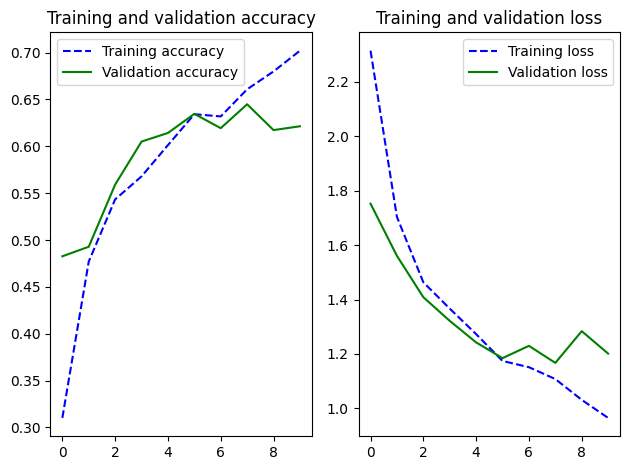

In [48]:
plot_training_analysis(vgg_combined_history)

In [55]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(val_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)


 
t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

92/92 ━━━━━━━━━━━━━━━━━━━━ 405s 4s/step - accuracy: 0.7078 - loss: 0.9097
31/31 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.6245 - loss: 1.1866


/home/gadj/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.6550 - loss: 1.1599
Train accuracy: 0.7068437337875366
Validation accuracy: 0.6214285492897034
Test accuracy: 0.6357142925262451
Time Prediction: 683.16 seconds


# Second Approach: FineTunning Transfer learning with data augmentation

In [57]:
conv_base.trainable = True

for layer in conv_base.layers[:15]:
    layer.trainable = False

vgg_combined.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,996,920 (129.69 MB)

 Trainable params: 13,506,834 (51.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 12,854,822 (49.04 MB)

In [58]:
epochs = 5

vgg_combined.compile(
    loss = 'CategoricalCrossentropy',
    optimizer = Adam(learning_rate=1e-4), # Reduced learning rates to avoid smashing everything and risking overfitting
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = val_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 657s 7s/step - accuracy: 0.6017 - loss: 1.2568 - val_accuracy: 0.5612 - val_loss: 1.4339
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 664s 7s/step - accuracy: 0.7306 - loss: 0.8663 - val_accuracy: 0.6571 - val_loss: 1.1373
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 645s 7s/step - accuracy: 0.7699 - loss: 0.7205 - val_accuracy: 0.6806 - val_loss: 1.0991
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 643s 7s/step - accuracy: 0.7990 - loss: 0.6127 - val_accuracy: 0.6582 - val_loss: 1.2424
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 636s 7s/step - accuracy: 0.8367 - loss: 0.5362 - val_accuracy: 0.6653 - val_loss: 1.1694
Learning time for 5 epochs : 3291 seconds


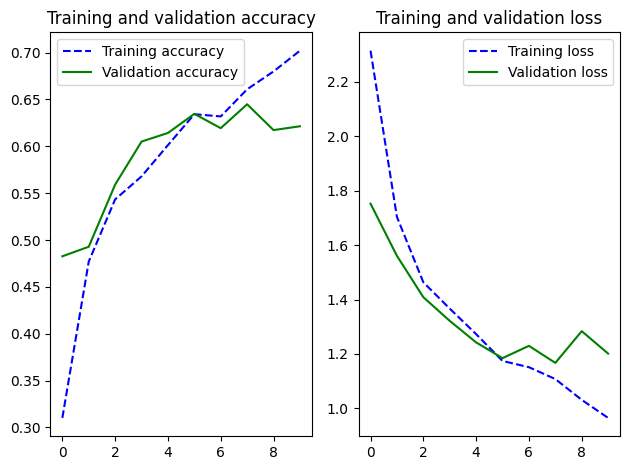

In [59]:
plot_training_analysis(vgg_combined_history)

In [61]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(val_generator)
score_vgg_combined_test= vgg_combined.evaluate(test_generator)


 
t_prediction_vgg_combined= time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print('Test accuracy:', score_vgg_combined_test[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

92/92 ━━━━━━━━━━━━━━━━━━━━ 408s 4s/step - accuracy: 0.8696 - loss: 0.4498
31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6634 - loss: 1.1245
31/31 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6817 - loss: 1.2267
Train accuracy: 0.8617637157440186
Validation accuracy: 0.6653061509132385
Test accuracy: 0.7020407915115356
Time Prediction: 709.82 seconds
